In [2]:
import pandas as pd
import numpy as np
import datasets
import torch
import os
from datasets import load_dataset, load_from_disk, concatenate_datasets
from transformers import EarlyStoppingCallback, AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification
from transformers import Trainer
from sklearn.model_selection import train_test_split
import evaluate

In [3]:
dataset = load_dataset('../data/ReviewPrediction', data_files={'train': 'train.csv', 'test': 'test.csv', 'validation': 'validation.csv'})
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 7656
    })
    test: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 1423
    })
    validation: Dataset({
        features: ['Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 403
    })
})

## BERT base german cased - transformers trainer

In [4]:
checkpoint = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['review'], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset["train"][0]

{'Unnamed: 0': 2347,
 '_id': '61e0642e1875bb0021077478',
 'review': 'Alles irreführend mit diesem Kurs: Prüfungsrelevante Inhalte, Prüfungsfragen, Aufsicht oder keine Aufsicht, Dias und vieles mehr!',
 'score': 1,
 'upvotes': 0.0,
 'downvotes': 0.0,
 'sum': 0,
 'input_ids': [3,
  10795,
  18140,
  24387,
  114,
  798,
  6436,
  26964,
  10575,
  18017,
  26,
  13940,
  26918,
  10575,
  5521,
  26918,
  12671,
  309,
  668,
  12671,
  26918,
  1824,
  45,
  42,
  17422,
  380,
  26982,
  4],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [5]:
tokenized_dataset = tokenized_dataset.remove_columns(["upvotes", "downvotes", "score", "Unnamed: 0", '_id', 'review'])
tokenized_dataset = tokenized_dataset.rename_column("sum", "labels")
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7656
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1423
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 403
    })
})

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
torch.cuda.is_available()

True

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics import classification_report, accuracy_score

def compute_metrics(eval_preds):
    results = {}
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    class_report= classification_report(y_pred=predictions, y_true=labels)
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    print("############ Classification report ############")
    print(class_report)
    print("############      Accuracy       ##############")
    print(acc)
    results.update({'classification report' : class_report})
    results.update({'accuracy':acc})
    return results

training_args = TrainingArguments(
    'test-trainer', 
    auto_find_batch_size=True,
    #gradient_accumulation_steps=4,
    evaluation_strategy="epoch", 
    num_train_epochs=3,
    #per_device_train_batch_size=4,  
    #per_device_eval_batch_size=1,
    #eval_accumulation_steps=1,
    learning_rate=1e-5,
    #save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [9]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Classification report,Accuracy
1,1.324200,1.442410,precision recall f1-score support 0 0.70 1.00 0.83 283 1 0.00 0.00 0.00 99 2 0.00 0.00 0.00 12 3 0.00 0.00 0.00 9 accuracy 0.70 403 macro avg 0.18 0.25 0.21 403 weighted avg 0.49 0.70 0.58 403,0.702233
2,1.247000,1.990767,precision recall f1-score support 0 0.71 0.95 0.81 283 1 0.17 0.04 0.07 99 2 0.00 0.00 0.00 12 3 0.50 0.11 0.18 9 accuracy 0.68 403 macro avg 0.35 0.27 0.26 403 weighted avg 0.55 0.68 0.59 403,0.677419
3,1.120800,2.204541,precision recall f1-score support 0 0.73 0.88 0.80 283 1 0.33 0.19 0.24 99 2 0.00 0.00 0.00 12 3 0.33 0.11 0.17 9 accuracy 0.67 403 macro avg 0.35 0.30 0.30 403 weighted avg 0.60 0.67 0.62 403,0.667494


############ Classification report ############
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       283
           1       0.00      0.00      0.00        99
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         9

    accuracy                           0.70       403
   macro avg       0.18      0.25      0.21       403
weighted avg       0.49      0.70      0.58       403

############      Accuracy       ##############
0.7022332506203474


C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############ Classification report ############
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       283
           1       0.17      0.04      0.07        99
           2       0.00      0.00      0.00        12
           3       0.50      0.11      0.18         9

    accuracy                           0.68       403
   macro avg       0.35      0.27      0.26       403
weighted avg       0.55      0.68      0.59       403

############      Accuracy       ##############
0.6774193548387096


C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


############ Classification report ############
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       283
           1       0.33      0.19      0.24        99
           2       0.00      0.00      0.00        12
           3       0.33      0.11      0.17         9

    accuracy                           0.67       403
   macro avg       0.35      0.30      0.30       403
weighted avg       0.60      0.67      0.62       403

############      Accuracy       ##############
0.6674937965260546


C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=11484, training_loss=1.255251861540377, metrics={'train_runtime': 1507.9243, 'train_samples_per_second': 15.232, 'train_steps_per_second': 7.616, 'total_flos': 755824745430144.0, 'train_loss': 1.255251861540377, 'epoch': 3.0})

## Hyperparameter optimization  - BERT base german cased

In [7]:
# Hyperparameter optimization
def optuna_hp_space(trial):
    return{
        "learning_rate" : trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32, 64, 128])
    }

In [10]:
import optuna

def objective(trial: optuna.Trial):     
    model,
    training_args = TrainingArguments(         
        output_dir='./hp_optimization',
        learning_rate=trial.suggest_float('learning_rate', low=1e-6, high=0.01),         
        weight_decay=trial.suggest_float('weight_decay', 4e-5, 0.01),         
        num_train_epochs=trial.suggest_int('num_train_epochs', low=2,high=8),         
        #per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32, 64, 128]),         
        #per_device_eval_batch_size=trial.suggest_categorical("per_device_eval_batch_size", [4, 8, 16, 32, 64, 128]),         
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        disable_tqdm=True)     

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['validation'],
        data_collator=data_collator,
        tokenizer=tokenizer,
        #compute_metrics=compute_metrics,
    )
    
    result = trainer.train()     
    return result.training_loss

In [11]:
#----------------------------------------------------------------------------------------------------
#                    CREATE OPTUNA STUDY
#----------------------------------------------------------------------------------------------------

print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-electra', direction='minimize') 
study.optimize(func=objective, n_trials=20) 

[I 2023-10-17 16:35:51,981] A new study created in memory with name: hp-search-electra


Triggering Optuna study


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
[W 2023-10-17 16:36:06,293] Trial 0 failed with parameters: {'learning_rate': 0.008665374934488372, 'weight_decay': 0.005422559322396213, 'num_train_epochs': 4} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 4.00 GiB total capacity; 3.22 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\jorge\AppData\Local\Temp\ipyke

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 4.00 GiB total capacity; 3.22 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Weighted loss function trainer - BERT german cased

In [8]:
# Training with weight balanced loss

from sklearn.metrics import classification_report, accuracy_score
from torch import nn


class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.03, 0.08, 0.39, 0.5], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_preds):
    results = {}
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    class_report= classification_report(y_pred=predictions, y_true=labels)
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    print("############ Classification report ############")
    print(class_report)
    print("############      Accuracy       ##############")
    print(acc)
    results.update({'classification report' : class_report})
    results.update({'accuracy':acc})
    return results

training_args = TrainingArguments(
    'test-trainer', 
    auto_find_batch_size=True,
    #gradient_accumulation_steps=4,
    evaluation_strategy="epoch", 
    num_train_epochs=3,
    #per_device_train_batch_size=4,  
    #per_device_eval_batch_size=1,
    eval_accumulation_steps=1,
    learning_rate=1e-5,
    #save_strategy="epoch",
    #load_best_model_at_end=True
)

trainer = CustomLossTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

In [9]:
model.save_pretrained('../models/ReviewPrediction/model_01_01_68')
tokenizer.save_pretrained('../models/ReviewPrediction/tokenizer_01_01_68')

('../models/ReviewPrediction/tokenizer_01_01_68\\tokenizer_config.json',
 '../models/ReviewPrediction/tokenizer_01_01_68\\special_tokens_map.json',
 '../models/ReviewPrediction/tokenizer_01_01_68\\vocab.txt',
 '../models/ReviewPrediction/tokenizer_01_01_68\\added_tokens.json',
 '../models/ReviewPrediction/tokenizer_01_01_68\\tokenizer.json')

In [9]:
predictions = trainer.predict(tokenized_dataset["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

############ Classification report ############
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       283
           1       0.32      0.16      0.21        99
           2       0.00      0.00      0.00        12
           3       0.40      0.22      0.29         9

    accuracy                           0.68       403
   macro avg       0.36      0.32      0.33       403
weighted avg       0.60      0.68      0.63       403

############      Accuracy       ##############
0.6774193548387096


C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(403, 4) (403,)


In [10]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

print(accuracy_metric.compute(predictions=preds, references=predictions.label_ids))
print(precision_metric.compute(predictions=preds, references=predictions.label_ids, average='macro'))
print(recall_metric.compute(predictions=preds, references=predictions.label_ids, average='macro'))
print(f1_metric.compute(predictions=preds, references=predictions.label_ids, average='macro'))

{'accuracy': 0.6774193548387096}
{'precision': 0.36318965517241375}
{'recall': 0.3212246136274405}
{'f1': 0.32718006846640424}


C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
preds

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       3, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## BERT base multilingual uncased sentiment - fine tuning attempt in Colab due to OOM exception

In [11]:
checkpoint = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['review'], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset["train"][0]

{'Unnamed: 0': 2347,
 '_id': '61e0642e1875bb0021077478',
 'review': 'Alles irreführend mit diesem Kurs: Prüfungsrelevante Inhalte, Prüfungsfragen, Aufsicht oder keine Aufsicht, Dias und vieles mehr!',
 'score': 1,
 'upvotes': 0.0,
 'downvotes': 0.0,
 'sum': 0,
 'input_ids': [101,
  21785,
  10544,
  61581,
  19544,
  56772,
  10234,
  14296,
  33666,
  131,
  14853,
  77644,
  37696,
  12832,
  33248,
  10111,
  95942,
  10111,
  117,
  14853,
  77644,
  45220,
  41533,
  117,
  10350,
  47707,
  10843,
  14819,
  10350,
  47707,
  117,
  14347,
  10138,
  16994,
  10107,
  12600,
  106,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [12]:
tokenized_dataset = tokenized_dataset.remove_columns(["upvotes", "downvotes", "score", "Unnamed: 0", '_id', 'review'])
tokenized_dataset = tokenized_dataset.rename_column("sum", "labels")
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7656
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1423
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 403
    })
})

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
torch.cuda.is_available()

True

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from sklearn.metrics import classification_report, accuracy_score

def compute_metrics(eval_preds):
    results = {}
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    class_report= classification_report(y_pred=predictions, y_true=labels)
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    print("############ Classification report ############")
    print(class_report)
    print("############      Accuracy       ##############")
    print(acc)
    results.update({'classification report' : class_report})
    results.update({'accuracy':acc})
    return results

training_args = TrainingArguments(
    'test-trainer', 
    evaluation_strategy="epoch", 
    auto_find_batch_size=True,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

## Load local model

In [1]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import evaluate
import torch

dataset = load_dataset('../data/ReviewPrediction', data_files={'test': 'test.csv'})

tokenizer = AutoTokenizer.from_pretrained("../models/ReviewPrediction/tokenizer_01_01_68")
model = AutoModelForSequenceClassification.from_pretrained("../models/ReviewPrediction/model_01_01_68")

def tokenize_function(example):
    return tokenizer(example["review"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["upvotes", "downvotes", "score", "Unnamed: 0", '_id', 'review'])
tokenized_dataset = tokenized_dataset.rename_column("sum", "labels")
tokenized_dataset

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1423
    })
})

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [3]:
# Dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = torch.utils.data.DataLoader(tokenized_dataset["test"], batch_size=8, collate_fn=data_collator)

all_preds = []
all_labels = []

metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

model.eval()
for batch in test_dataloader:
    batch = {k:v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())
    metric.add_batch(predictions=preds, references=batch["labels"])
    f1_metric.add_batch(predictions=preds, references=batch["labels"])
    
print(metric.compute())
print(f1_metric.compute(average='macro'))

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'accuracy': 0.6106816584680252}
{'f1': 0.24745731465755627}


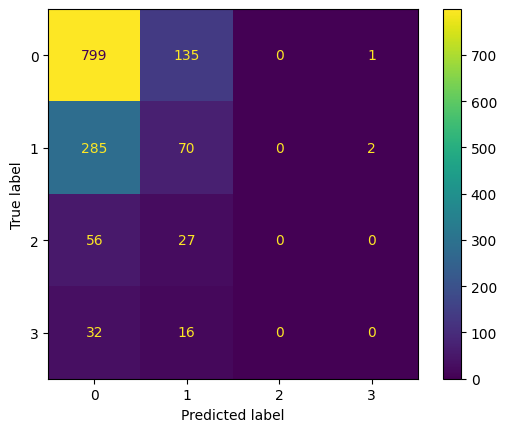

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()

In [5]:
from huggingface_hub import login
login()

In [7]:
model.push_to_hub("jorgeortizv/reviewUsefulness-multiclassClassification")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jorgeortizv/reviewUsefulness-multiclassClassification/commit/84db749369fe0ac259384e28fd3a3c574a4ae497', commit_message='Upload BertForSequenceClassification', commit_description='', oid='84db749369fe0ac259384e28fd3a3c574a4ae497', pr_url=None, pr_revision=None, pr_num=None)

In [8]:
tokenizer.push_to_hub("jorgeortizv/reviewUsefulness-multiclassClassification")

CommitInfo(commit_url='https://huggingface.co/jorgeortizv/reviewUsefulness-multiclassClassification/commit/68b5f63f1cd995aef3ef476b714a1ffb40df23d8', commit_message='Upload tokenizer', commit_description='', oid='68b5f63f1cd995aef3ef476b714a1ffb40df23d8', pr_url=None, pr_revision=None, pr_num=None)